# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob
path = 'data/final/train/'
all_files = glob.glob(path + '*.csv')
# list to append csvs
l = []
# loop over all files
for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=0)
    l.append(df_tmp)

# Add all data frames together
df = pd.concat(l, axis=0, ignore_index=True)

In [3]:
df.columns

Index(['backers_count', 'blurb', 'category', 'country', 'currency', 'goal',
       'pledged', 'slug', 'spotlight', 'staff_pick', 'state', 'usd_pledged',
       'usd_type', 'goal_usd', 'word_count', 'month_launched', 'days_running'],
      dtype='object')

In [4]:
df.describe().round(2)

,backers_count,goal,pledged,usd_pledged,goal_usd,word_count,month_launched,days_running
count,173361.00,1.733610e+05,173361.00,173361.00,1.733610e+05,173361.00,173361.00,173361.00
mean,151.99,4.519420e+04,19365.55,13451.84,3.718445e+04,18.95,6.45,32.44
std,878.56,1.100140e+06,302306.45,87085.50,1.011273e+06,5.07,3.36,11.64
min,0.00,1.000000e-02,0.00,0.00,1.000000e-02,1.00,1.00,1.00
25%,4.00,1.500000e+03,150.00,149.66,1.500000e+03,16.00,4.00,30.00
50%,30.00,5.000000e+03,1791.00,1765.00,5.000000e+03,20.00,7.00,30.00
75%,95.00,1.500000e+04,7463.21,7093.03,1.250000e+04,22.00,9.00,34.00
max,105857.00,1.000000e+08,81030744.00,8596474.58,1.059990e+08,85.00,12.00,93.00


## Category

In [5]:
print("There are {} different categories in the given dataset!".format(df.category.unique().shape[0]))

There are 15 different categories in the given dataset!


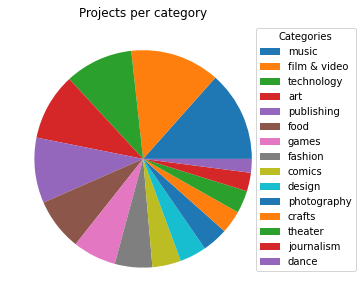

In [6]:
category = df.category.value_counts()
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(category)
ax.legend(category.index,
          title="Categories",
          loc="upper right",
          bbox_to_anchor=(1.3,1),
          prop={'size': 10});
ax.set_title('Projects per category');

In [7]:
count_total = df.query('state != "live"').category.value_counts().sort_index()

category = df.groupby('category')

count_success = category.state.apply(lambda x: (x=='successful').sum()).reset_index(name='count')

category = pd.DataFrame({'category': count_success['category'],
                         'total': count_total.values,
                         'success': count_success['count'],
                         'success_rate': count_success['count']/count_total.values})

category = category.sort_values('success_rate', ascending=False).round(2)

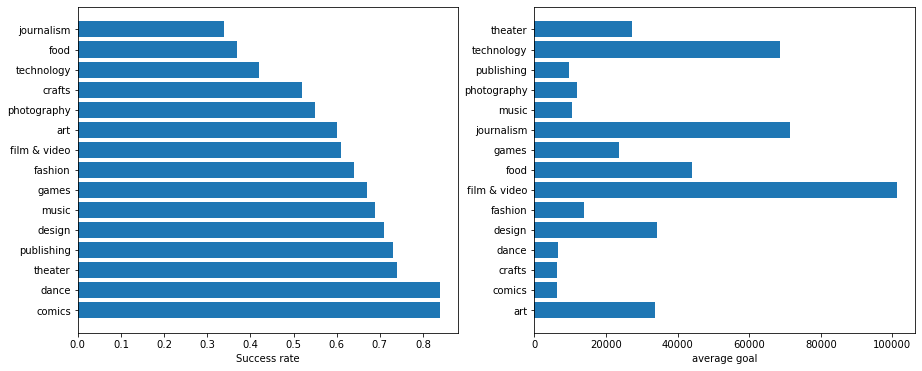

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].barh(category.category, category.success_rate)
ax[0].set_xlabel('Success rate');

category = df.groupby('category').mean()
ax[1].barh(category.index, category.goal_usd)
ax[1].set_xlabel('average goal');


Clearly some categories are more successful then others! Can be used as __dummy varibles__, but maybe need to include one 'other' dummy to account for not given categories! Also to make clear to customer, that some categories are probable to fail!\
Technology needs lots of  money, maybe that's a reason for bad success rate. Opposite for dance and comics, need very few money and have a good success rate!

# Quartals launched at
Compare the quartal the project launched, with the count of projects and the success rate.

In [9]:
quarter = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4}
df['launched_quarter'] = [quarter[i] for i in df.month_launched]

Text(0.5, 1.0, 'number of projects per quartal')

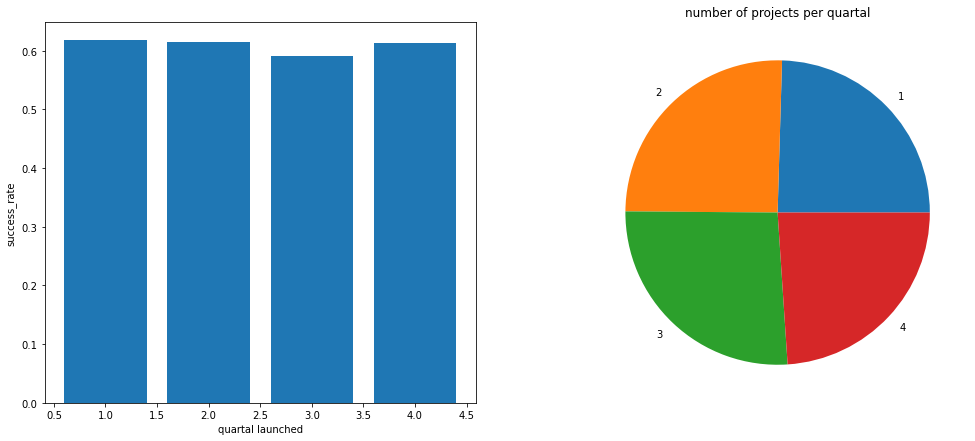

In [10]:
quarter = df.groupby('launched_quarter')
quarter_df = quarter.state.apply(lambda x: (x=='successful').sum()).reset_index(name='count_success')
quarter_df['count_total'] = quarter.size().values

fig, ax = plt.subplots(1,2, figsize=(17,7))
ax[0].bar(quarter_df.launched_quarter, quarter_df.count_success/quarter_df.count_total);
ax[0].set_xlabel('quartal launched')
ax[0].set_ylabel('success_rate')
ax[1].pie(quarter_df.count_total, labels=quarter_df.launched_quarter);
ax[1].set_title('number of projects per quartal');

Time of year has no influence on projects success, project can be started at any time!

# Days of project from start to end

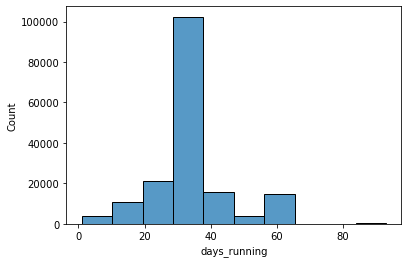

In [11]:
sns.histplot(data=df, x='days_running', bins=10);

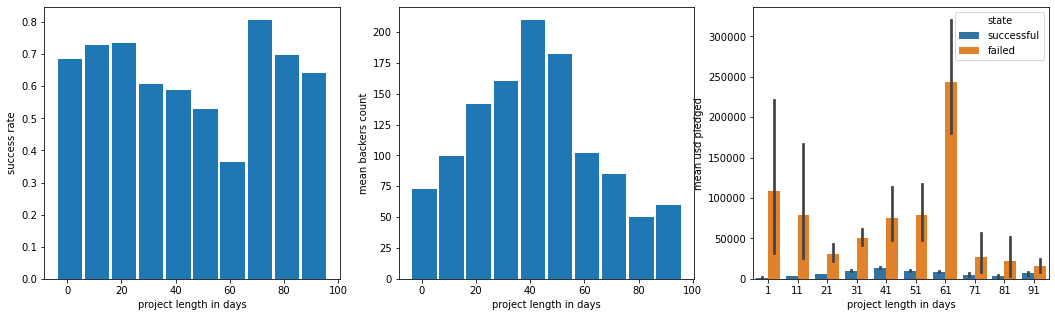

In [48]:
tmp_df = df.copy()
nbins=10
labels = np.arange(df.days_running.min(), df.days_running.max(), nbins)
tmp_df['bins'] = pd.cut(df.days_running, bins=nbins, labels=labels)

width = 9
days = tmp_df.groupby('bins')
days_df = days.state.apply(lambda x: (x=='successful').sum()).reset_index(name='count_success')
days_df['count_total'] = days.size().values
days_df['rate'] = days_df.count_success/days_df.count_total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(days_df.bins, days_df.count_success/days_df.count_total, width=width);
ax[0].set_xlabel('project length in days')
ax[0].set_ylabel('success rate')

days = tmp_df.groupby('bins').mean()
ax[1].bar(days.index, days.backers_count, width=width)
ax[1].set_xlabel('project length in days')
ax[1].set_ylabel('mean backers count')

days = tmp_df.groupby('bins').mean()
sns.barplot(data=tmp_df, x='bins', y='goal_usd', hue='state', ax=ax[2])
#ax[2].bar(days.index, days.usd_pledged, width=width)
ax[2].set_xlabel('project length in days')
ax[2].set_ylabel('mean usd pledged');

Most __successful__ projects are either __short (10-30 days)__ or __long (70-80 days)__. Most money/bakers settle for medium sized projects (40-60 days)

# Blurb length

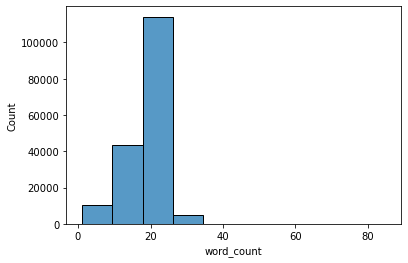

In [14]:
sns.histplot(data=df, x='word_count', bins=10);

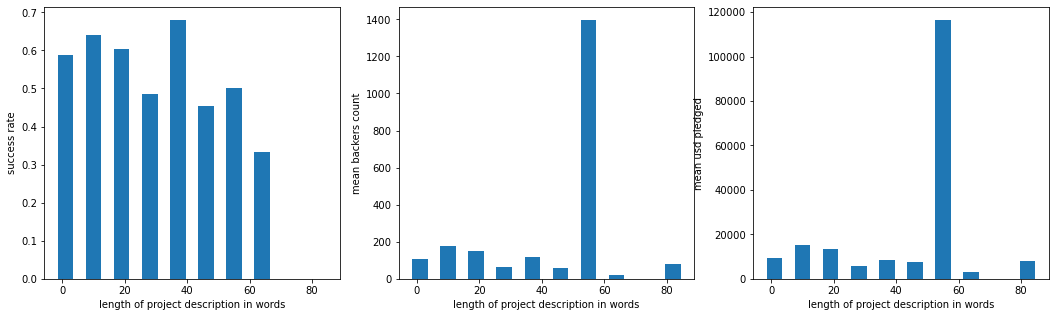

In [40]:
nbins=10
width = 5
x_feature = 'word_count'

tmp_df = df.copy()
labels = np.arange(df[x_feature].min(), df[x_feature].max(), nbins-1)
tmp_df['bins'] = pd.cut(df[x_feature], bins=nbins, labels=labels)
x_feature = 'bins'

tmp = tmp_df.groupby(x_feature)
tmp2_df = tmp.state.apply(lambda x: (x=='successful').sum()).reset_index(name='success')
tmp2_df['total'] = tmp.size().values
tmp2_df['rate'] = tmp2_df.success/tmp2_df.total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(tmp2_df[x_feature], tmp2_df.success/tmp2_df.total, width=width);
ax[0].set_xlabel('length of project description in words')
ax[0].set_ylabel('success rate')

tmp = tmp_df.groupby(x_feature).mean()
ax[1].bar(tmp.index, tmp.backers_count, width=width)
ax[1].set_xlabel('length of project description in words')
ax[1].set_ylabel('mean backers count')

tmp = tmp_df.groupby(x_feature).mean()
ax[2].bar(tmp.index, tmp.usd_pledged, width=width)
ax[2].set_xlabel('length of project description in words')
ax[2].set_ylabel('mean usd pledged');

Descriptions of __10 to 40 words are most successful__!

__Look for outliers!!!__

In [16]:
# Plot goal, success_rate and word_count together!

# Country

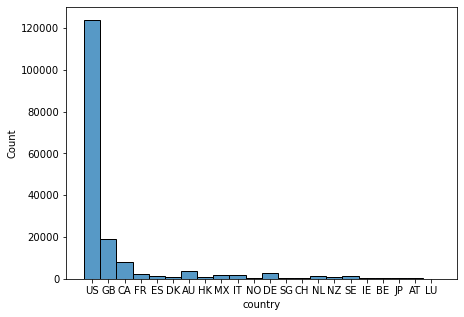

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(data=df, x='country', ax=ax);

Most projects are from US!

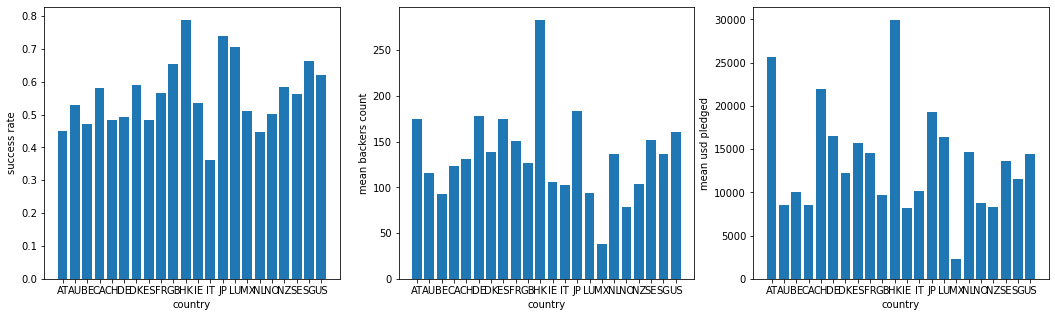

In [18]:
tmp = df.groupby('country')
tmp_df = tmp.state.apply(lambda x: (x=='successful').sum()).reset_index(name='success')
tmp_df['total'] = tmp.size().values
tmp_df['rate'] = tmp_df.success/tmp_df.total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(tmp_df.country, tmp_df.success/tmp_df.total);
ax[0].set_xlabel('country')
ax[0].set_ylabel('success rate')

tmp = df.groupby('country').mean()
ax[1].bar(tmp.index, tmp.backers_count)
ax[1].set_xlabel('country')
ax[1].set_ylabel('mean backers count')

tmp = df.groupby('country').mean()
ax[2].bar(tmp.index, tmp.usd_pledged)
ax[2].set_xlabel('country')
ax[2].set_ylabel('mean usd pledged');

Success does not depend on country! But country could be important for money pledged -> project goal!

# Currency

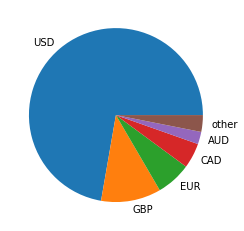

In [42]:
first_five = df.currency.value_counts()[:5]
rest = df.currency.value_counts()[6:].sum()
series = pd.Series(rest, index=['other'])
first_five = first_five.append(series)
plt.pie(first_five, labels=first_five.index);

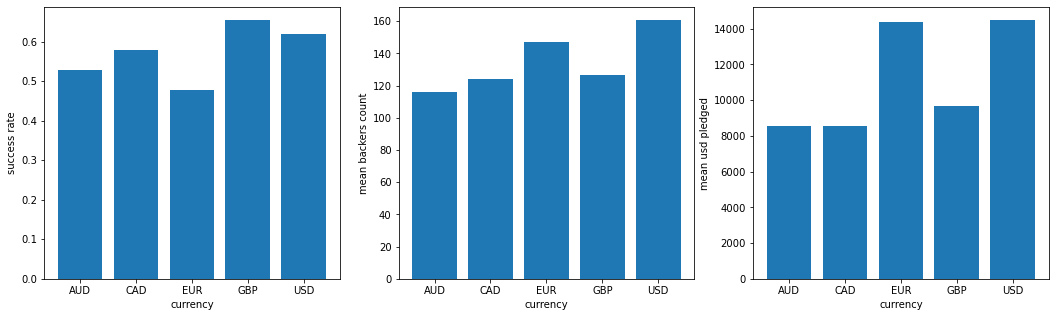

In [21]:
tmp = df.query('currency == ["USD", "GBP", "EUR", "CAD", "AUD", "rest"]').groupby('currency')
tmp_df = tmp.state.apply(lambda x: (x=='successful').sum()).reset_index(name='success')
tmp_df['total'] = tmp.size().values
tmp_df['rate'] = tmp_df.success/tmp_df.total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(tmp_df.currency, tmp_df.success/tmp_df.total);
ax[0].set_xlabel('currency')
ax[0].set_ylabel('success rate')

tmp = df.query('currency == ["USD", "GBP", "EUR", "CAD", "AUD", "rest"]').groupby('currency').mean()
ax[1].bar(tmp.index, tmp.backers_count)
ax[1].set_xlabel('currency')
ax[1].set_ylabel('mean backers count')

tmp = df.query('currency == ["USD", "GBP", "EUR", "CAD", "AUD", "rest"]').groupby('currency').mean()
ax[2].bar(tmp.index, tmp.usd_pledged)
ax[2].set_xlabel('currency')
ax[2].set_ylabel('mean usd pledged');

Currency/Region is not important for successor bakers count. But in __Europe and US__ more usd are pledged, maybe only there start __very expensive projects__!

# Spotlight and staff_pick

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


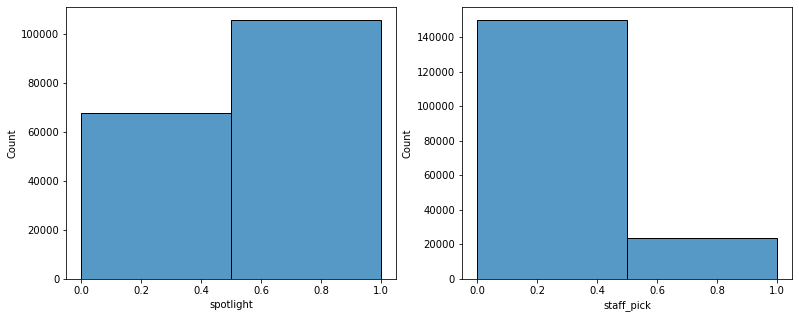

In [22]:
fig, ax = plt.subplots(1,2,figsize=(13,5))
sns.histplot(data=df, x='spotlight', ax=ax[0], bins=2)
sns.histplot(data=df, x='staff_pick', ax=ax[1], bins=2);

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


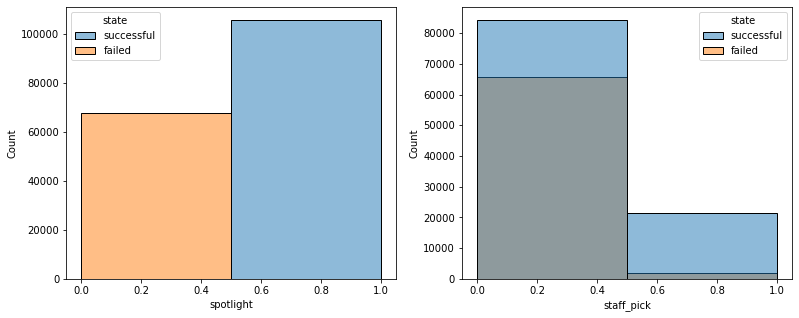

In [23]:
fig, ax = plt.subplots(1,2,figsize=(13,5))
sns.histplot(data=df, x='spotlight', hue='state', bins=2, ax=ax[0])
sns.histplot(data=df, x='staff_pick', hue='state', bins=2, ax=ax[1]);

All spotlight Trues are successes, and False are fails. Probably the __values are false__. __Remove__ them from data set!

Most projects are not highligted by __staff pick__. But the __fail rate is much lower__, if they are!

In [41]:
#remove outliers if ralf found some

# Feature Importance

# Blurb to dict

decision tree show where obs fails?